# Bias correcting precipitation

* Should we apply the BC using a (e.g.) 15-day rolling window? or all Januarys, Februarys etc ??
* How should we account for missing observational data?
* What quality control checks should we do on the station data before we use it?
* How do we correct for elevation? e.g., regression using monthly sum precipitation?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import optimize, spatial
import matplotlib.pyplot as plt

In [2]:
def cv_diff(a, series, target_cv):
    '''
    Returns the difference between the coefficient of variation of the input 
        series and the target coefficient of variation. This value is then 
        minimised in order to find the power-correction coefficients needed
    Input:
        a : power-correction coefficient to be tested
        series : time-series that needs to be corrected in order to match its 
            coefficient of variation with target_cv
        target_cv : target coefficient of variation for the time-series
    Output:
        cv_diff : difference between the target coefficient of variation and 
            the coefficient of variation of the series after having been 
            raised to the power of a; this value should be minimised through 
            an iterative scheme
    '''
    series_new = np.power(series, a)
    cv_new = np.std(series_new) / np.mean(series_new)
    cv_diff = target_cv - cv_new
    return cv_diff


def correct_series_coeffs(series, target_mean, target_cv):
    '''
    Returns the power-correction coefficients that are needed in order to 
        correct the series and increase the rainfall variability. If the 
        optimization algorithm fails to converge, it will leave the 
        coefficient of variation unchanged and match the mean by setting 
        the b coefficient to 1
    Input:
        series - time-series that needs to be corrected in order to match its 
            coefficient of variation with target_cv
        target_mean - target mean for the time-series
        target_cv - target coefficient of variation for the time-series
    Output:
        a - linear coefficient that the entire series is multiplied by
        b - coefficient that the entire series is raised to
    '''
    try:
        b = optimize.newton(cv_diff, 1.0, args = (series, target_cv), 
                                tol = 1.48e-05, maxiter = 100)
    except RuntimeError:
        b = 1
    series_corrected_cv = np.power(series, b)
    a = target_mean / np.mean(series_corrected_cv)
    return a, b

In [3]:
def get_nearest_point(df, lon_label, lat_label, my_lon, my_lat):
    df1 = df.groupby([lon_label, lat_label]).mean().reset_index()
    xs = df1[lon_label].values
    ys = df1[lat_label].values
    tree = spatial.KDTree(list(zip(xs, ys)))
    d, i = tree.query( [(my_lon, my_lat)], k=1)
    df = df[ (df[lon_label] == xs[i][0]) & (df[lat_label] == ys[i][0]) ]
    return df

## Read in data

In [4]:
### Example for a single station named 'Suni' for a period where we have a 
### complete set of daily data
lon, lat   = 77.164200, 31.2303
year_range = [2008, 2013]

### Model Data

In [5]:
model_data = pd.read_csv('../envkrig/Data/WRF_precip_1D_1980-2015.csv.gz')
model_dates = pd.DatetimeIndex(model_data['Time'])
model_data['year'] = model_dates.year
model_data['doy']  = model_dates.dayofyear
model_data = model_data[ (model_dates.year >= year_range[0]) & (model_dates.year <= year_range[1]) ]
model_data['Total_Rain'] = model_data['RAINC'] + model_data['RAINNC']
model_data.head()

,Time,lat,lon,RAINC,RAINNC,year,doy,Total_Rain
1636320,2008-01-01,29.597431,75.117004,0.0,0.0,2008,1,0.0
1636321,2008-01-02,29.597431,75.117004,0.0,0.0,2008,2,0.0
1636322,2008-01-03,29.597431,75.117004,0.0,0.0,2008,3,0.0
1636323,2008-01-04,29.597431,75.117004,0.0,0.0,2008,4,0.0
1636324,2008-01-05,29.597431,75.117004,0.0,0.0,2008,5,0.0


In [6]:
model_data = get_nearest_point(model_data, 'lon', 'lat', lon, lat)
model_data = model_data.reset_index(drop=True)
print( 'Expected vs Actual ndays = ', len(np.unique(model_data['year'].values))*365.25, len(model_data))
model_data.head()

Expected vs Actual ndays =  2191.5 2192


,Time,lat,lon,RAINC,RAINNC,year,doy,Total_Rain
0,2008-01-01,31.00657,77.146666,0.0,0.000000,2008,1,0.000000
1,2008-01-02,31.00657,77.146666,0.0,0.000000,2008,2,0.000000
2,2008-01-03,31.00657,77.146666,0.0,0.000812,2008,3,0.000812
3,2008-01-04,31.00657,77.146666,0.0,0.003708,2008,4,0.003708
4,2008-01-05,31.00657,77.146666,0.0,0.635166,2008,5,0.635166


### Station Data 

In [7]:
obs_data  = pd.read_csv('../envkrig/Data/rainfall_data.csv').drop(labels=['Unnamed: 0'], axis=1)
obs_dates = pd.DatetimeIndex(obs_data.Date)
obs_data['year'] = obs_dates.year
obs_data['doy'] = obs_dates.dayofyear
obs_data.head()

,Date,Station_Name,Longitude,Latitude,Altitude,Rainfall,year,doy
0,1975-03-05,"SHIQUANHE, CH",80.083,32.5,4280.0,0.0,1975,64
1,1975-06-22,"SHIQUANHE, CH",80.083,32.5,4280.0,1.0,1975,173
2,1975-07-21,"SHIQUANHE, CH",80.083,32.5,4280.0,7.1,1975,202
3,1978-03-12,"SHIQUANHE, CH",80.083,32.5,4280.0,1.0,1978,71
4,1979-06-05,"SHIQUANHE, CH",80.083,32.5,4280.0,0.0,1979,156


In [8]:
obs_data = obs_data[ (obs_dates.year >= year_range[0]) & (obs_dates.year <= year_range[1]) ]
obs_data = get_nearest_point(obs_data, 'Longitude', 'Latitude', lon, lat).reset_index(drop=True)
print( 'Expected vs Actual ndays = ', len(np.unique(obs_data['year'].values))*365.25, len(obs_data))
obs_data.head()

Expected vs Actual ndays =  2191.5 2192


,Date,Station_Name,Longitude,Latitude,Altitude,Rainfall,year,doy
0,2008-01-01,SUNI,77.108333,31.2375,655.0,0.0,2008,1
1,2008-02-01,SUNI,77.108333,31.2375,655.0,0.0,2008,32
2,2008-03-01,SUNI,77.108333,31.2375,655.0,0.0,2008,61
3,2008-04-01,SUNI,77.108333,31.2375,655.0,0.0,2008,92
4,2008-05-01,SUNI,77.108333,31.2375,655.0,0.0,2008,122


In [9]:
### Sanity check...
if len(obs_data) != len(model_data):
    print(len(obs_data), len(model_data))
    raise ValueError('Timeseries are not the same length')
    
if all(obs_data.doy == model_data.doy):
    raise ValueError('Day of year columns do not match')

### Apply Bias Correction

In [10]:
target_mean = obs_data['Rainfall'].values.mean() # mean for closest station 
target_sd   = obs_data['Rainfall'].values.std()  # std for closest station
target_cv   = target_sd / target_mean

a_coeff, b_coeff   = correct_series_coeffs(model_data['Total_Rain'].values, target_mean, target_cv)
print(a_coeff, b_coeff)

0.9062582333942119 0.9424487226670006


In [11]:
corrected_rainfall = a_coeff * (np.power(model_data['Total_Rain'].values, b_coeff))
model_data['Corrected_Rain'] = corrected_rainfall

### Compare statistics

In [12]:
for v in [model_data['Total_Rain'], obs_data['Rainfall'], model_data['Corrected_Rain']]:
    print(v.name.ljust(15)+':', v.values.mean(), v.values.std())

Total_Rain     : 4.065324387598479 16.299922739654537
Rainfall       : 3.0108576642335763 11.193726687195097
Corrected_Rain : 3.0108576642335763 11.19372668723725


### Plotting

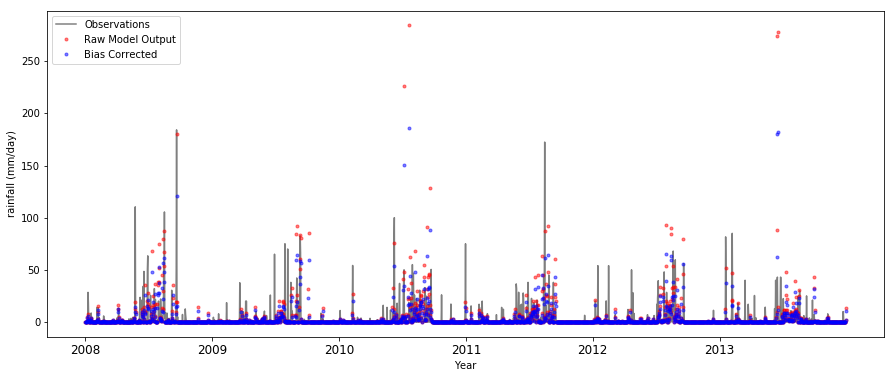

In [13]:
f, ax = plt.subplots(figsize=[15,6])

ax.plot(obs_data.index,   obs_data['Rainfall'],         'k-', alpha=0.5, label='Observations')
ax.plot(model_data.index, model_data['Total_Rain'],     'r.', alpha=0.5, label='Raw Model Output')
ax.plot(model_data.index, model_data['Corrected_Rain'], 'b.', alpha=0.5, label='Bias Corrected')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('rainfall (mm/day)')

### label xaxis with years
ind = model_data['doy'].values == 1
labels = model_data['year'].values[ind]
ax.set_xticks(model_data.index[ind])
ax.set_xticklabels(labels, fontdict=None, minor=False, visible=True, size='large')
print('')

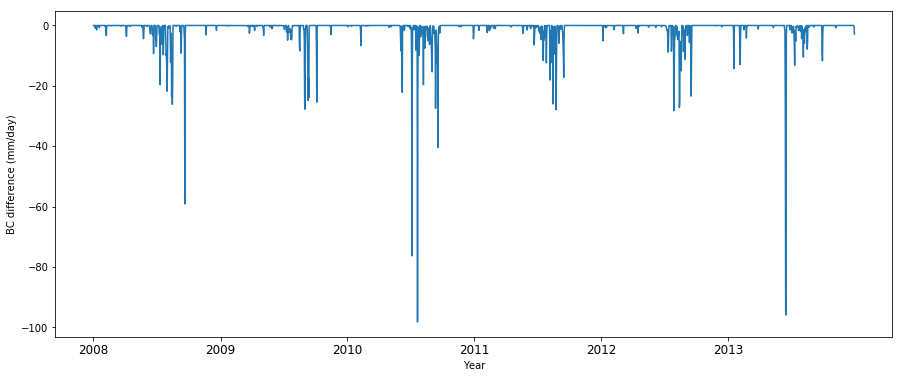

In [14]:
### difference between corrected and raw model output
f, ax = plt.subplots(figsize=[15,6])
ax.plot(model_data.index, model_data['Corrected_Rain']-model_data['Total_Rain'])
ax.set_xlabel('Year')
ax.set_ylabel('BC difference (mm/day)')

### label xaxis with years
ind = model_data['doy'].values == 1
labels = model_data['year'].values[ind]
ax.set_xticks(model_data.index[ind])
ax.set_xticklabels(labels, fontdict=None, minor=False, visible=True, size='large')
print('')